# RESULTS NMNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 60000
number of samples in the testing set: 10000


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

## Unsupervised clustering

In [5]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

## Training of the classification layer

In [6]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 1.7e7

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, testset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 4-(b))

In [7]:
likelihood, true_target, timestamps = predict_mlr(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

In [ ]:
mlr_threshold = None
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

In [ ]:
mlr_threshold = .99
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [7]:
kfold_jitter = 1000
nb_trials = 1
nb_points = 5

trainset_output_jitter = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

(array([ 0. ,  2.5,  5. ,  7.5, 10. ]),
 array([[1. , 0.4, 0.2, 0.1, 0.1]]),
 array([[0.9, 0.2, 0.1, 0.1, 0.1]]),
 array([[0.9, 0.1, 0.1, 0.1, 0.1]]))

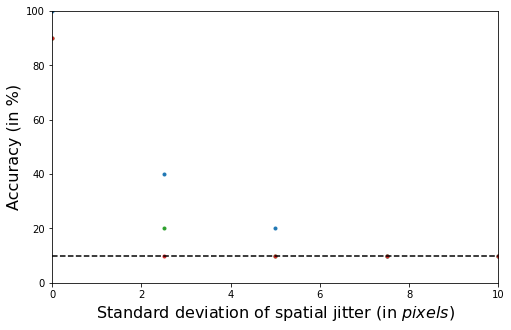

In [8]:
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, fitting = False, verbose = True)

## Robustness to temporal jitter (Figure 5-(b)-(down))

(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
 array([[1. , 1. , 0.6, 0.1, 0.1]]),
 array([[0.9, 0.9, 0.2, 0.1, 0. ]]),
 array([[0.9, 0.9, 0.1, 0.1, 0. ]]))

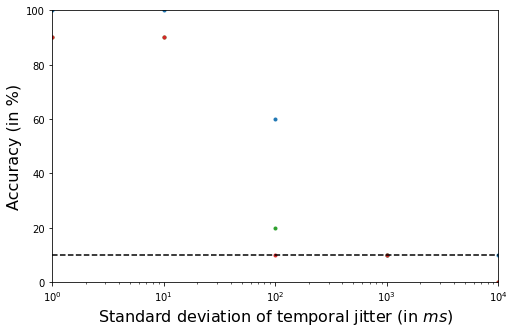

In [10]:
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, fitting = False, verbose = True)